In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt


In [14]:
device = (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
print("Using device:", device)

Using device: mps


# Data Loader

In [15]:
class KGDataLoader:
    def __init__(self):
        self.cfg = {
            'item2id_path': 'data/item_index2entity_id.txt',
            'kg_path': 'data/kg.txt',
            'rating_path': 'data/user_artists.dat',
            'rating_sep': '\t',
            'threshold': 0.0
        }

        # Load files
        df_item2id = pd.read_csv(self.cfg['item2id_path'], sep='\t', header=None, names=['item', 'id'])
        df_kg = pd.read_csv(self.cfg['kg_path'], sep='\t', header=None, names=['head', 'relation', 'tail'])
        df_rating = pd.read_csv(self.cfg['rating_path'], sep=self.cfg['rating_sep'], 
                                names=['userID', 'itemID', 'rating'], skiprows=1)

        # Filter only items that exist in item2id
        df_rating = df_rating[df_rating['itemID'].isin(df_item2id['item'])]
        df_rating.reset_index(inplace=True, drop=True)

        self.df_item2id = df_item2id
        self.df_kg = df_kg
        self.df_rating = df_rating

        self.user_encoder = LabelEncoder()
        self.entity_encoder = LabelEncoder()
        self.relation_encoder = LabelEncoder()

        self._encoding()

    def _encoding(self):
        self.user_encoder.fit(self.df_rating['userID'])
        self.entity_encoder.fit(pd.concat([self.df_item2id['id'], self.df_kg['head'], self.df_kg['tail']]))
        self.relation_encoder.fit(self.df_kg['relation'])

        self.df_kg['head'] = self.entity_encoder.transform(self.df_kg['head'])
        self.df_kg['tail'] = self.entity_encoder.transform(self.df_kg['tail'])
        self.df_kg['relation'] = self.relation_encoder.transform(self.df_kg['relation'])

    def _build_dataset(self):
        print('Build dataset dataframe ...', end=' ')
        df_dataset = pd.DataFrame()
        df_dataset['userID'] = self.user_encoder.transform(self.df_rating['userID'])

        item2id_dict = dict(zip(self.df_item2id['item'], self.df_item2id['id']))
        self.df_rating['itemID'] = self.df_rating['itemID'].apply(lambda x: item2id_dict[x])
        df_dataset['itemID'] = self.entity_encoder.transform(self.df_rating['itemID'])
        df_dataset['label'] = self.df_rating['rating'].apply(lambda x: 0 if x < self.cfg['threshold'] else 1)

        df_dataset = df_dataset[df_dataset['label'] == 1]

        full_item_set = set(range(len(self.entity_encoder.classes_)))
        user_list, item_list, label_list = [], [], []
        for user, group in df_dataset.groupby('userID').__iter__():
            item_set = set(group['itemID'])
            negative_set = full_item_set - item_set
            negative_sampled = random.sample(list(negative_set), len(item_set))
            user_list.extend([user] * len(negative_sampled))
            item_list.extend(negative_sampled)
            label_list.extend([0] * len(negative_sampled))

        negative = pd.DataFrame({'userID': user_list, 'itemID': item_list, 'label': label_list})
        df_dataset = pd.concat([df_dataset, negative])

        df_dataset = df_dataset.sample(frac=1, replace=False, random_state=999)
        df_dataset.reset_index(inplace=True, drop=True)

        print('Done')
        return df_dataset

    def _construct_kg(self):
        print('Construct knowledge graph ...', end=' ')
        kg = dict()
        for i in range(len(self.df_kg)):
            head = self.df_kg.iloc[i]['head']
            relation = self.df_kg.iloc[i]['relation']
            tail = self.df_kg.iloc[i]['tail']
            if head in kg:
                kg[head].append((relation, tail))
            else:
                kg[head] = [(relation, tail)]
            if tail in kg:
                kg[tail].append((relation, head))
            else:
                kg[tail] = [(relation, head)]

        print('Done')
        return kg

    def load_dataset(self):
        return self._build_dataset()

    def load_kg(self):
        return self._construct_kg()

    def get_encoders(self):
        return (self.user_encoder, self.entity_encoder, self.relation_encoder)

    def get_num(self):
        return (len(self.user_encoder.classes_), len(self.entity_encoder.classes_), len(self.relation_encoder.classes_))

In [16]:
data_loader = KGDataLoader()  # 클래스 인스턴스 생성
df_dataset = data_loader.load_dataset()  # 인스턴스를 통해 메서드 호출

print("레이블 분포:")
print(df_dataset['label'].value_counts())
print("\n레이블 비율 (%):")
print(df_dataset['label'].value_counts(normalize=True) * 100)


Build dataset dataframe ... Done
레이블 분포:
label
1    21173
0    21173
Name: count, dtype: int64

레이블 비율 (%):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


In [17]:
loader = KGDataLoader()

df_dataset = loader.load_dataset()

print(df_dataset.dtypes)

Build dataset dataframe ... Done
userID    int64
itemID    int64
label     int64
dtype: object


In [18]:
class Aggregator(torch.nn.Module):
    
    def __init__(self, batch_size, dim, aggregator):
        super(Aggregator, self).__init__()
        self.batch_size = batch_size
        self.dim = dim
        if aggregator == 'concat':
            self.weights = torch.nn.Linear(2 * dim, dim, bias=True)
        else:
            self.weights = torch.nn.Linear(dim, dim, bias=True)
        self.aggregator = aggregator
        
    def forward(self, self_vectors, neighbor_vectors, neighbor_relations, user_embeddings, act):
        batch_size = user_embeddings.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        neighbors_agg = self._mix_neighbor_vectors(neighbor_vectors, neighbor_relations, user_embeddings)
        
        if self.aggregator == 'sum':
            output = (self_vectors + neighbors_agg).view((-1, self.dim))
            
        elif self.aggregator == 'concat':
            output = torch.cat((self_vectors, neighbors_agg), dim=-1)
            output = output.view((-1, 2 * self.dim))
            
        else:
            output = neighbors_agg.view((-1, self.dim))
            
        output = self.weights(output)
        return act(output.view((self.batch_size, -1, self.dim)))
        
    def _mix_neighbor_vectors(self, neighbor_vectors, neighbor_relations, user_embeddings):
        # [batch_size, 1, dim] -> [batch_size, 1, 1, dim]
        user_embeddings = user_embeddings.view((self.batch_size, 1, 1, self.dim))
        
        # [batch_size, -1, n_neighbor, dim] -> [batch_size, -1, n_neighbor]
        user_relation_scores = (user_embeddings * neighbor_relations).sum(dim = -1)
        user_relation_scores_normalized = F.softmax(user_relation_scores, dim = -1)
        
        # [batch_size, -1, n_neighbor] -> [batch_size, -1, n_neighbor, 1]
        user_relation_scores_normalized = user_relation_scores_normalized.unsqueeze(dim = -1)
        
        # [batch_size, -1, n_neighbor, 1] * [batch_size, -1, n_neighbor, dim] -> [batch_size, -1, dim]
        neighbors_aggregated = (user_relation_scores_normalized * neighbor_vectors).sum(dim = 2)
        
        return neighbors_aggregated

In [19]:
class KGCN(torch.nn.Module):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(KGCN, self).__init__()
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.n_iter = args.n_iter
        self.batch_size = args.batch_size
        self.dim = args.dim
        self.n_neighbor = args.neighbor_sample_size
        self.kg = kg
        self.device = device
        self.aggregator = Aggregator(self.batch_size, self.dim, args.aggregator)
        
        self._gen_adj()
            
        self.usr = torch.nn.Embedding(num_user, args.dim)
        self.ent = torch.nn.Embedding(num_ent, args.dim)
        self.rel = torch.nn.Embedding(num_rel, args.dim)
        
    def _gen_adj(self):
        self.adj_ent = torch.empty(self.num_ent, self.n_neighbor, dtype=torch.long)
        self.adj_rel = torch.empty(self.num_ent, self.n_neighbor, dtype=torch.long)
        
        for e in self.kg:
            if len(self.kg[e]) >= self.n_neighbor:
                neighbors = random.sample(self.kg[e], self.n_neighbor)
            else:
                neighbors = random.choices(self.kg[e], k=self.n_neighbor)
                
            self.adj_ent[e] = torch.LongTensor([ent for _, ent in neighbors])
            self.adj_rel[e] = torch.LongTensor([rel for rel, _ in neighbors])
        
    def forward(self, u, v):
        batch_size = u.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        # change to [batch_size, 1]
        u = u.view((-1, 1))
        v = v.view((-1, 1))
        
        # [batch_size, dim]
        user_embeddings = self.usr(u).squeeze(dim = 1)
        
        entities, relations = self._get_neighbors(v)
        
        item_embeddings = self._aggregate(user_embeddings, entities, relations)
        
        scores = (user_embeddings * item_embeddings).sum(dim = 1)
            
        return torch.sigmoid(scores)
    
    def _get_neighbors(self, v):
        entities = [v]
        relations = []
        
        for h in range(self.n_iter):
            neighbor_entities = torch.LongTensor(self.adj_ent[entities[h].cpu()]).view((self.batch_size, -1)).to(self.device)
            neighbor_relations = torch.LongTensor(self.adj_rel[entities[h].cpu()]).view((self.batch_size, -1)).to(self.device)

            entities.append(neighbor_entities)
            relations.append(neighbor_relations)
            
        return entities, relations
    
    def _aggregate(self, user_embeddings, entities, relations):
        entity_vectors = [self.ent(entity) for entity in entities]
        relation_vectors = [self.rel(relation) for relation in relations]
        
        for i in range(self.n_iter):
            if i == self.n_iter - 1:
                act = torch.tanh
            else:
                act = torch.sigmoid
            
            entity_vectors_next_iter = []
            for hop in range(self.n_iter - i):
                vector = self.aggregator(
                    self_vectors=entity_vectors[hop],
                    neighbor_vectors=entity_vectors[hop + 1].view((self.batch_size, -1, self.n_neighbor, self.dim)),
                    neighbor_relations=relation_vectors[hop].view((self.batch_size, -1, self.n_neighbor, self.dim)),
                    user_embeddings=user_embeddings,
                    act=act)
                entity_vectors_next_iter.append(vector)
            entity_vectors = entity_vectors_next_iter
        
        return entity_vectors[0].view((self.batch_size, self.dim))

In [20]:
# build dataset and knowledge graph
data_loader = KGDataLoader()
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,1217,289,1
1,1648,7886,0
2,596,9204,0
3,475,57,1
4,1450,3250,0
...,...,...,...
42341,1778,2720,0
42342,519,4,1
42343,1487,2879,1
42344,1115,36,1


In [21]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [22]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=20, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [24]:
# 데이터셋 구성
train_data = TensorDataset(
    torch.LongTensor(df_dataset['userID'].values),
    torch.LongTensor(df_dataset['itemID'].values),
    torch.FloatTensor(df_dataset['label'].values)
)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)

n_user, n_entity, n_relation = loader.get_num()

kg_dict = loader.load_kg()

Construct knowledge graph ... Done


In [25]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [26]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

device:  mps


In [27]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

[Epoch 1]train_loss:  1.100111726979564
[Epoch 1]test_loss:  1.0737547383588903
[Epoch 2]train_loss:  1.0186033168233426
[Epoch 2]test_loss:  0.9997699891819674
[Epoch 3]train_loss:  0.9396498732100752
[Epoch 3]test_loss:  0.9262269226943746
[Epoch 4]train_loss:  0.8666714653932959
[Epoch 4]test_loss:  0.8577408282195821
[Epoch 5]train_loss:  0.8043439979840042
[Epoch 5]test_loss:  0.8001324026023641
[Epoch 6]train_loss:  0.7568578684240356
[Epoch 6]test_loss:  0.7576656411675846
[Epoch 7]train_loss:  0.7253223684497345
[Epoch 7]test_loss:  0.7303906679153442
[Epoch 8]train_loss:  0.7069703837982694
[Epoch 8]test_loss:  0.7146985004929935
[Epoch 9]train_loss:  0.697274000572979
[Epoch 9]test_loss:  0.7061994163429036
[Epoch 10]train_loss:  0.6923736105287882
[Epoch 10]test_loss:  0.7016479267793543
[Epoch 11]train_loss:  0.6898711238588605
[Epoch 11]test_loss:  0.6991525344988879
[Epoch 12]train_loss:  0.6885081068017429
[Epoch 12]test_loss:  0.6977237708428327
[Epoch 13]train_loss:  0

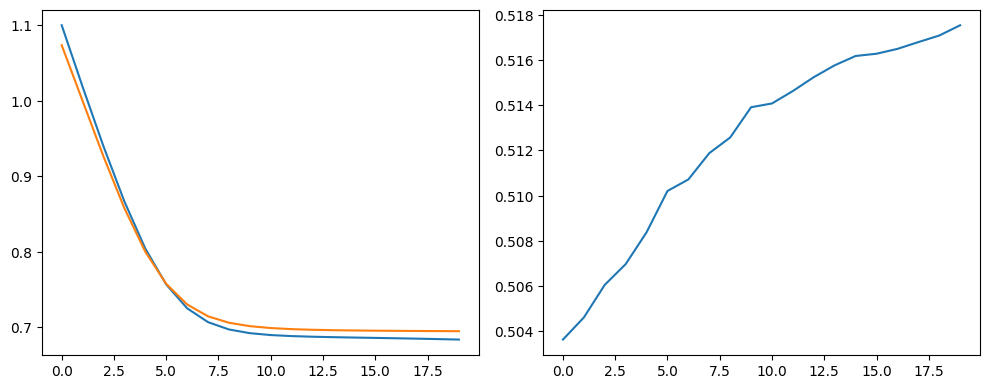

In [28]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)

plt.tight_layout()